# Clasificación galaxias fusionandose

Este proyecto creará un modelo de clasificación para definir si una galaxia se está fusionando o no.

In [58]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, classification_report, precision_score
import time
import matplotlib.pyplot as plt

## Limpieza y tratamiento de los datos

### Descargamos los datasets

In [59]:
path_morphology = r"C:/Users/Usuario/Documents/datasets de glaxias/morphology_catalogue.csv"
data_morph = pd.read_csv(path_morphology)

path_physical = r"C:/Users/Usuario/Documents/datasets de glaxias/useful_physical_measurements.parquet"
data_phys = pd.read_parquet(path_physical)


Vamos a tomar las variables que mas nos interesan a la hora de inferir si se están fusionando o no, y además, de las variables que nos dicen que están fusionando (merging).

In [60]:
variables_morph = ['object_id', 'mumax_minus_mag', 'mag_segmentation', 'ellipticity', 'kron_radius', 'smooth-or-featured_smooth_fraction', 'smooth-or-featured_featured-or-disk_fraction',
                   'merging_none_fraction', 'merging_minor-disturbance_fraction', 'merging_major-disturbance_fraction', 'merging_merger_fraction']
variables_phys = ['object_id', 'concentration', 'gini', 'asymmetry', 'moment_20', 'sersic_sersic_vis_index', 'phz_pp_median_stellarmass']

data = pd.merge(
    left= data_phys[variables_phys],
    right= data_morph[variables_morph],
    on= 'object_id',
    how= "inner"
)

In [ ]:
# Existen valores infinitos y NaN, vamos a eliminarlos

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()

tamaño_df, num_variables = data.shape
print(f'Tras limpiar el dataset, trabajaremos con {tamaño_df} galaxias y influirán {num_variables - 4} variables para inferir si se están fusionando\n')
print(data.head(1).T)

Tras limpiar el dataset, trabajaremos con 361945 galaxias y influirán 13 variables para inferir si se están fusionando

                                                         0
object_id                                    -5.189475e+17
concentration                                 2.305792e+00
gini                                          6.205372e-01
asymmetry                                     2.475280e-01
moment_20                                    -1.256248e+00
sersic_sersic_vis_index                       4.111770e-01
phz_pp_median_stellarmass                     1.096292e+01
mumax_minus_mag                               2.266884e-02
mag_segmentation                              2.091707e+01
ellipticity                                   2.185057e-01
kron_radius                                   5.737984e+01
smooth-or-featured_smooth_fraction            3.166504e-01
smooth-or-featured_featured-or-disk_fraction  5.703125e-01
merging_none_fraction                         5.595703

### CREAMOS EL CONJUNTO CON EL QUE INFERIREMOS SI LAS GALAXIAS SE ESTAN FUSIONANDO, (i.e. ELIMINAMOS LAS COLUMNAS "merging")

In [62]:
X = data.drop(['merging_none_fraction', 'merging_minor-disturbance_fraction', 'merging_major-disturbance_fraction', 'merging_merger_fraction'], axis=1)

print(X.shape)
print(X.head(1).T)

(361945, 13)
                                                         0
object_id                                    -5.189475e+17
concentration                                 2.305792e+00
gini                                          6.205372e-01
asymmetry                                     2.475280e-01
moment_20                                    -1.256248e+00
sersic_sersic_vis_index                       4.111770e-01
phz_pp_median_stellarmass                     1.096292e+01
mumax_minus_mag                               2.266884e-02
mag_segmentation                              2.091707e+01
ellipticity                                   2.185057e-01
kron_radius                                   5.737984e+01
smooth-or-featured_smooth_fraction            3.166504e-01
smooth-or-featured_featured-or-disk_fraction  5.703125e-01


### CREAMOS LAS DIFERENTES CLASES
Le daremos el valor de 0 si es mayor la probabilidad que no exista ningun indicio de fusión. Daremos 1 si hay algún indicio de fusión.

In [63]:
data['Merging'] = 0

data['Merging'] = (data['merging_none_fraction'] < 0.5).astype(int)
y = data['Merging']

print(y.value_counts())

Merging
0    264014
1     97931
Name: count, dtype: int64


Las galaxias con un indicio de fusión están infrarepresentadas

## PREPARAR LOS DATOS PARA ENTRENAMIENTO Y PRUEBA, ADEMÁS DE ESTANDARIZAR LOS DATOS

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

Estandarizamos las muestras:

In [65]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns= X_train.columns, index= X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns= X_test.columns, index= X_test.index)

## CREAMOS LOS MODELOS DONDE VAMOS A IMPLEMENTAR LOS DATOS

In [ ]:
## Random Forest
rf = RandomForestClassifier(
    n_estimators= 200,
    max_depth= 8,
    class_weight= 'balanced',
    n_jobs= -1
)


## XGBoosting
xgb = XGBClassifier(n_estimators=100,
                    learning_rate=0.05,
                    max_depth=3,
                    scale_pos_weight=5,  # un peso por encima de lo que debería (2.6)
                    objective='binary:logistic',
                    n_jobs=-1,
                    eval_metric='auc'
                    )

### ENTRENAMIENTO Y PREDICIONES DE LOS MODELOS

In [67]:
start_time_rf = time.time()
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test_scaled)
y_probs_rf = rf.predict_proba(X_test_scaled)[:, 1] 
y_pred_rf_ajusted = (y_probs_rf >= 0.4).astype(int)
end_time_rf = time.time()
rf_train_time = end_time_rf - start_time_rf

#---------------------------------#

start_time_xgb = time.time()
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test_scaled)
y_probs_xgb = xgb.predict_proba(X_test_scaled)[:, 1] 
y_pred_xgb_ajusted = (y_probs_xgb >= 0.35).astype(int)
end_time_xgb = time.time()
xgb_train_time = end_time_xgb - start_time_xgb


print(f'Tiempo de entrenamiento y predicción de XGBoosting: {xgb_train_time} segundos')
print(f'Tiempo de entrenamiento y prendicción de Random Forest: {rf_train_time} segundos')

Tiempo de entrenamiento y predicción de XGBoosting: 0.38713574409484863 segundos
Tiempo de entrenamiento y prendicción de Random Forest: 17.77590775489807 segundos


## EVALUACIÓN DE LOS MODELOS

In [69]:
print('\n~~~~~~~~~~~~~~ EVALUACION DE Random Forest ~~~~~~~~~~~~~~')
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_rf_ajusted):.4f}")
print(f'F1-score:  {f1_score(y_test, y_pred_rf_ajusted):.4f}')
print(f'Recall:   {recall_score(y_test, y_pred_rf_ajusted):.4f}')
print(f'Precision:   {precision_score(y_test, y_pred_rf_ajusted):.4f}')
print('Confusion matrix:\n')
print(confusion_matrix(y_test, y_pred_rf_ajusted))


~~~~~~~~~~~~~~ EVALUACION DE Random Forest ~~~~~~~~~~~~~~
AUC-ROC Score: 0.7065
F1-score:  0.5754
Recall:   0.5145
Precision:   0.6526
Confusion matrix:

[[71157  8048]
 [14263 15116]]


In [68]:
print('\n~~~~~~~~~~~~~~ EVALUACION DE XGBoosting ~~~~~~~~~~~~~~')
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_xgb_ajusted):.4f}")
print(f'F1-score:  {f1_score(y_test, y_pred_xgb_ajusted):.4f}')
print(f'Recall:   {recall_score(y_test, y_pred_xgb_ajusted):.4f}')
print(f'Precision:   {precision_score(y_test, y_pred_xgb_ajusted):.4f}')
print('Confusion matrix:\n')
print(confusion_matrix(y_test, y_pred_xgb_ajusted))


~~~~~~~~~~~~~~ EVALUACION DE XGBoosting ~~~~~~~~~~~~~~
AUC-ROC Score: 0.7017
F1-score:  0.5681
Recall:   0.4998
Precision:   0.6580
Confusion matrix:

[[71574  7631]
 [14696 14683]]


Los modelos no son altamente precisos. Además, podemos observar que los modelos tienen problemas a la hora de discernir si las galaxias se están fusionando o no y declaran muchas galaxias como que no se están fusionando cuando en realidad sí.


## GRAFICAS DE PREDICCION

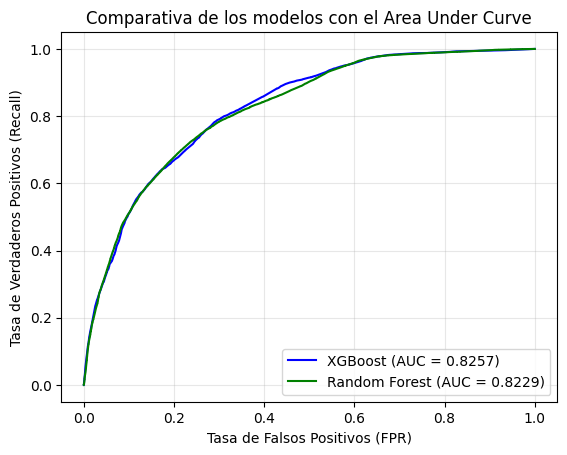

In [70]:
# Tasa de falsos y verdaderos positivos
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_probs_xgb)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)

# Calculamos el AUC Score para ponerlo en la leyenda
auc_xgb = roc_auc_score(y_test, y_probs_xgb)
auc_rf = roc_auc_score(y_test, y_probs_rf)


## GRAFICA:
# Curva XGBoost
plt.plot(fpr_xgb, tpr_xgb, color='blue', label=f'XGBoost (AUC = {auc_xgb:.4f})')

# Curva Random Forest
plt.plot(fpr_rf, tpr_rf, color='green', label=f'Random Forest (AUC = {auc_rf:.4f})')

# Decoración del gráfico
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (Recall)')
plt.title('Comparativa de los modelos con el Area Under Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.show()

### Importancia de las variables

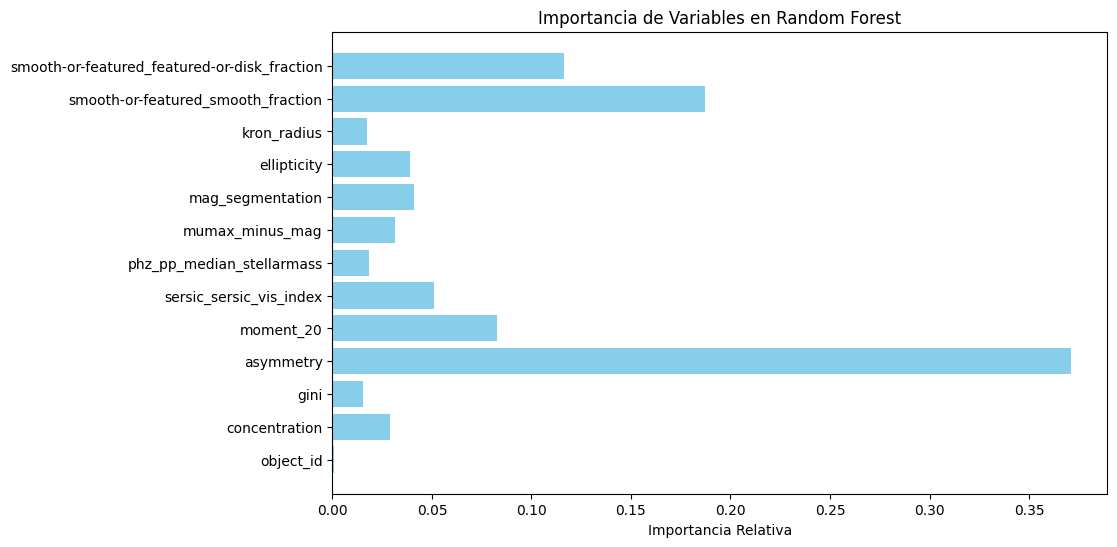

In [71]:
### Random forest ###
importances_rf = rf.feature_importances_
feature_names = X.columns

# Grafica
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances_rf, color='skyblue')
plt.xlabel('Importancia Relativa')
plt.title('Importancia de Variables en Random Forest')
plt.show()

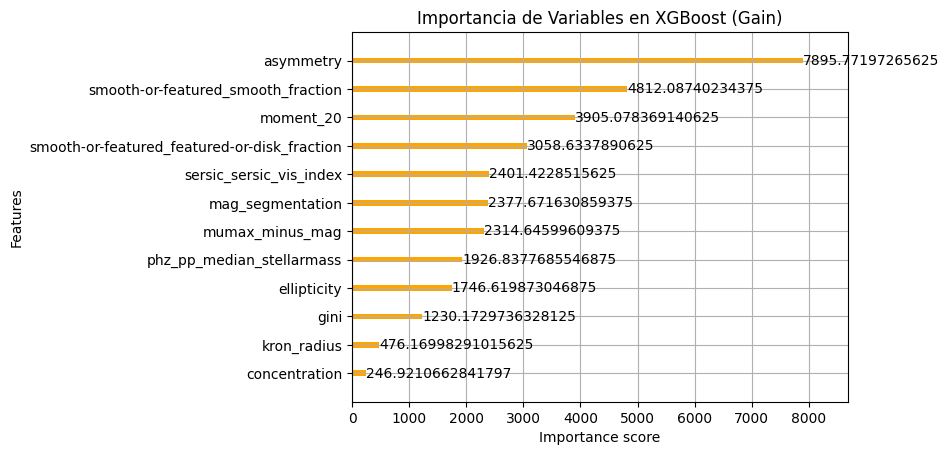

In [72]:
### XGBoost ###
plot_importance(xgb, importance_type='gain', color='orange')
plt.title('Importancia de Variables en XGBoost (Gain)')
plt.show()

En aspectos generales, podemos observar que los dos modelos toman como más importantes las mismas variables.